<a id="1.Summary"></a>
# 1.Summary

Document Classifcation. You need to classify text paragraphs into three categories: Fyodor Dostoyevsky, Arthur Conan Doyle, and Jane Austen by building your own classifers. The data provided is from Project Gutenberg.
Most of parts have been writen into function. But for the final <code>__main__ </code>part, there are still some parts write didn't that well. Need future improvement.
<code>Logistci Regressan, Mini-batch and Stochasitc gradient descent</code> didn't use packages. Others, including <code>Neural Network</code> used packages

<a id="2.Contents"></a>
# 2.Contents
<a href="#1.Summary">Click this Link back to Top</a>

<ol>
    <li><a href="#1.Summary">Summary</a></li>
    <li><a href="#2.Contents">Contents</a></li>
    <li><a href="#3.Construct examples">Construct examples</a></li>
    <li><a href="#4.Preprocess data">4.Preprocess data / Feature Extraction</a></li>
    <li><a href="#5.Data split">Data split</a></li>
    <li><a href="#6.Train">Train</a></li>
    <ul>
       <li><a href="#6.1 Gradien Descent">6.1 Gradien Descent</a></li>
       <li><a href="#6.2 Mini-batch Gradient Descent">6.2 Mini-batch Gradient Descent</a></li> 
       <li><a href="#6.3 stochastic gradient descent">6.3 stochastic gradient descent</a></li>
       <li><a href="#6.4 Multilayer Perceptron">6.4 Multilayer Perceptron</a></li> 
    </ul>
    <li><a href="#7.Main">Main</a></li>
    <li><a href="#8.Cross-validation">Cross-validation</a></li>
    <li><a href="#9.Plot">Plot</a></li>
    <li><a href="#10.Compare Conclusion">Compare Conclusion</a></li>
</ol>


In [1]:
#if you want to rebuild identical environment, you can install follow this requirments
!conda list --export > requirements.txt

Active code page: 437


In [2]:
import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf

#we need use bs4 to eliminate html
from bs4 import BeautifulSoup

#it seems not working well
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold

#for the neural network part, we need use tensorflow and keras as backend
from tensorflow import keras
#keras only can complete simple text preprocess work
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from tensorflow.keras.models import Model


import matplotlib.pyplot as plt

#this function is used to monitor 
from tqdm import tqdm

<br>

<br>

<a id="3.Construct examples"></a>
# 3.Construct examples
<a href="#1.Summary">Click this Link back to Top</a>

Divde each document into multiple paragramps. Each graph will be one example, one element in list. Text in the begining to demenstrate info will be discarded. All data will be formed into a DataFrame, which have "AUTHOR" and "CLASSIFY" column

In [3]:
def data_import():
    """
    Each text have different issues, so i can not use one function to process all raw data
    
    Return:
    --------
    df:DataFrame
        concatenate all data into one DataFrame and add column name
    data_1:list
        from Fyodor Dostoyevsky,
    data_2:list
        from Arthur Conan Doyle,
    data_3:list
        from Jane Austen
    """
    #Due to txt contain 'gbk', we have to read this file as binary code style, but binary leave more issues
    with open('03_data/11_Project Gutenberg Data/28054-0.txt', 'rb') as f:
        #First we use normal read
        #Second, we should decode binary with utf-8, which will turn binary back to string
        #Thrid, we need split raw text into paragraph, according to data, 
        #every paragraph are seperated by '\r\n\r\n'
        #In binary new line is"\r\n\r\n". In string new line is "\n\n"
        lines_1 = f.read().decode('utf-8').split('\r\n\r\n')
    #we only need main content, so eliminate header of each raw data. 
    #We only keep content from first paragraph title
    index_1 = lines_1.index('Chapter I. Fyodor Pavlovitch Karamazov')
    data_1 = lines_1[index_1+1:]
    while("" in data_1) : 
        data_1.remove("") 
    print(f'For category one, Fyodor Dostoyevsky, we have {len(data_1)} examples')
    
    
    #lines_2 can read directly
    with open('03_data/11_Project Gutenberg Data/pg1661.txt') as f:
        #we can use '\n\n' to split paragraph
        lines_2 = f.read().split('\n\n')
    #we only want main content of this book
    index_2 = lines_2.index('\nADVENTURE I. A SCANDAL IN BOHEMIA') 
    #due to technical reason, i can't elimiate some extra paragraph, so we add two after index
    data_2 = lines_2[index_2+2:]
    while("" in data_2) : 
        data_2.remove("") 
    print(f'For category two, Arthur Conan Doyle, we have {len(data_2)} examples')
    
    
    with open('03_data/11_Project Gutenberg Data/pg31100.txt',  'rb') as f:
        lines_3 = f.read().decode('utf-8').split('\r\n\r\n')
    index_3 = lines_3.index('\r\nChapter 1')
    data_3 = lines_3[index_3+1:]
    while("" in data_3) : 
        data_3.remove("") 
    print(f'For category three, Fyodor Dostoyevsky, we have {len(data_3)} examples')
    
    #it's more convient to transform data into pandas DataFrame
    data = {'AUTHOR':data_1+data_2+data_3, 'CLASSIFY':[1]*len(data_1)+[2]*len(data_2)+[3]*len(data_3)}
    df = pd.DataFrame(data)
    
    """
    for i in range(0,len(lines_1)):
        try:
            lines_3[i] = lines_3[i].decode('utf-8')
    except:
        #n+=1
    print("'ascii' codec can't decode byte 0xe2 in position 47: ordinal not in")
    f.close()
    """
    
    return df

<br>

<br>

<br>

<a id="4.Preprocess data"></a>
# 4.Preprocess data / Feature Extraction
<a href="#1.Summary">Click this Link back to Top</a>

Remove punctuation, irrelevant symbols, urls, and numbers. You can remove the unrelated text in the beginning of each file.

I have two way to complete preprocessing progress. One is using keras.preprocess, another is using sklearn

In [4]:
def remove_pun(text):
    """
    The reason i use seperate function is that pandas.apply can manipulate with column value. 
    If we use loop directly, we will get a join corpus without paragraph structure
    """
    no_pun = "".join([c for c in text if c not in string.punctuation])
    return no_pun

In [5]:
def remove_html(text):
    """
    Use bs4 to extract text
    """
    soup = BeautifulSoup(text, 'lxml')
    no_html = soup.get_text()
    return no_html

In [6]:
def remove_regex(text):
    """
    It was designed to remove punctuation, but we can't manipulate with non string effectively
    """
    #remove url
    no_reg = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    #remove numbers
    no_reg = re.sub('\w*\d\w*', '', no_reg)
    return no_reg

In [16]:
def tfidf(df, vectorizer=None):
    """
    we use this function to complete preprocessing cleaning and tfidf function. Becuase we have to mentain 
    the relationship between corpus and his lable, we have several times list to DataFrame processes.
    I didn't show EDA part for setting up 
    
    Parameters:
    ------------
    df:pandas.DataFrame
        DataFrame, contain ['AUTHOR'] and ['CLASSIFY']. This is raw data.
        
    vectorizer:cofig
        When we apply to 
            
    Return:
    -------
    X_vector:array
        Dimension = (cleaned example, MAX_LEN).Cleaned data and transformed to TFIDF format 
        with original sequence, which means can be matched withcooresponding y_labels.
        
    y_vector:
        Dimension = (no. cleaned examples, NUM_LABELS)=(9630,3)
        
    
    """
    MAX_LEN = 10000
    
    #tokens = corpus.apply(lambda x: x.split())
    #tokens = word_tokenize(tokens)
    #tokens = word_tokenize(corpus.str)
    
    #Stemming and Lemmatizing:   
    #Coreference resolution
    
    #original datatype is serise, first transfrom to string and get lower() case text
    corpus_2 = df['AUTHOR'].str.lower()
    
    #using bs4 to eliminate html
    #soup = BeautifulSoup(corpus_2, 'lxml')
    #corpus_3 = soup.get_text()
    corpus_3 = corpus_2.apply(lambda x: remove_html(x))
    
    
    #any speical punctuation in filter sring should add "\" before it
    #corpus_3 = re.sub('\[.*?\]', '', corpus_2.to_string)
    #corpus_2.str.replace('\\r','',regex=True)
    #!"#$%&()*\+,-./:;<=>\?@\[\\\]^_`{|}~\\t\\n\\r\“
    corpus_4 = corpus_3.apply(lambda x: remove_regex(x))
    
    #use sring.puncutation to eliminate, but we should first remove url. I believe this should be last step
    corpus_5 = corpus_4.apply(lambda x: remove_pun(x))
    
    #only reserve words
    pattern=r'[a-zA-Z][-._a-zA-Z]*[a-zA-Z]'
    corpus_6 = [" ".join(re.findall(pattern, x)) for x in corpus_5]
    
    #we sitll need to manipulate with index because it contain important relationship between corpus and claasify
    #list to pd.Series
    corpus_7 = pd.Series(np.array(corpus_6))
    #extract classify column
    classify_col = df['CLASSIFY']
    #build a new data dictionary for generating DataFrame
    data_2 = {'AUTHOR':corpus_7, 'CLASSIFY':classify_col}
    #build a dataFrame with AUTHOR and CLASSIFY infomation. For now, the index of df and corpus_8 are identical
    corpus_8 = pd.DataFrame(data_2)
    
    
    #we can't directly drop column because index will dynamicly decrease, but we can gather index of drop
    index_drop=[]
    #iteration through all DataFrame
    for i in range(len(corpus_8)):
        #according to plot and statitc result,>600 have 2628, <60 have 3540, so we only need 60<data<600
        if len(corpus_8.iloc[i,0])<60 or len(corpus_8.iloc[i,0])>600:
            #delete too big and too small
            index_drop.append(i)
    print(f"before drop shape={corpus_8.shape}")
    
    #drop row by list but remain old index number
    corpus_9 = corpus_8.drop(index_drop,axis=0)
    print(f"after drop shape={corpus_9.shape}")
    #re.finall(\w+)  
    
    #inintial 

    if vectorizer == None:
        vectorizer = TfidfVectorizer(stop_words='english',max_features = MAX_LEN)
        #when we built a vect, we need to import all words as corpus combination to generate a TFIDF dictornary
        vect = vectorizer.fit([" ".join(corpus_9['AUTHOR'].tolist())])
        #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
        data_2 = vect.transform(corpus_9['AUTHOR']).toarray()
        X_vector = np.array(data_2)
    else:
        vect = vectorizer.fit([" ".join(corpus_9['AUTHOR'].tolist())])
        #after fit, we need to use dictionary to transform our coupus into TFIDF(we can use sum() to check sparse)
        X_vector = vect.transform(corpus_9['AUTHOR']).toarray()

    #To remain the relation between AUTHOR vector and CLASSIFY labels, we also output y_vector coorespondingly
    y_vector = mapped(corpus_9['CLASSIFY'])
#     data=None
#     vect=None
    return corpus_9, X_vector, y_vector, vect

In [9]:
"""
#This part is used for verify processing result
#this will show which vector was transfromed back to words. We use this output to compare with corpus[0]
#for instance, we can check data[5] related to corpus_9[5]. Except stopwords, they have same stem words

corpus_9, X_test_1, y_test_1, vect = tfidf(df)
vect.inverse_transform(data_4)[0]
corpus[0]
"""

'\n#This part is used for verify processing result\n#this will show which vector was transfromed back to words. We use this output to compare with corpus[0]\n#for instance, we can check data[5] related to corpus_9[5]. Except stopwords, they have same stem words\n\ncorpus_9, X_test_1, y_test_1, vect = tfidf(df)\nvect.inverse_transform(data_4)[0]\ncorpus[0]\n'

<br>

<br>

<a id="5.Data split"></a>
# 5.Data split
<a href="#1.Summary">Click this Link back to Top</a>

We split data equally into three pieces. Train 60%, Calidation 20%, Test 20%

In [10]:
def split(X_vector,y_vector, test_size=0.2):
    """
    Parameters:
    -----------
    df:DataFrame
        This is coming from data_import. This is still raw data with corpus inside. After data split
        tfidf() function will complete data preprocess
        
    test_size:float
        you can change percentage
    """
    X_train, X_test, y_train, y_test = train_test_split(X_vector, y_vector, \
                                                        test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [10]:
def data_split(data, label):
    """
    This function is used to split data into three part, 60% as traning, 20%as validataion and 20% as test
    In this part we still manipulate raw corpus, not vector result
    
    Parameters:
    ----------
    df:pd.DataFrame
        Contain column 'AUTHOR' and 'CLASSIFY'
        
        
    Return:
    ----------
    train_X:
    validation_X:
    test_X:
    train_y:
    validation_y:
    test_y:
    
    """
    #we can arrange percentage in this place
    m = data.shape[0]
    training_size = int(m * 0.6)
    validation_size = int(m * 0.8)
    print(f'Split data into three parts 0-{training_size} is train_part.\n')
    print(f'{training_size}-{validation_size} is validation_part.\n')       
    print(f'{validation_size}-{m} is test_part.\n')
    
    train_X = data[0:training_size]
    validation_X = data[training_size:validation_size]
    test_X = data[validation_size:]
    train_y = label[0:training_size]
    validation_y = label[training_size:validation_size]
    test_y = label[validation_size:]

    
    return train_X, validation_X, test_X, train_y, validation_y, test_y

#train_X, validation_X, test_X, train_y, validation_y, test_y = data_split(data_1, label_1)

def concatenate_df(df):
    """
    This function is used to merge train/validatoin/test with three different classfy
    
    Parameters:
    ----------
    
    Return:
    -------
    
    """
    #
    data_1 = df.loc[df['CLASSIFY']==1]['AUTHOR']
    label_1 = df.loc[df['CLASSIFY']==1]['CLASSIFY']
    data_2 = df.loc[df['CLASSIFY']==2]['AUTHOR']
    label_2 = df.loc[df['CLASSIFY']==2]['CLASSIFY']
    data_3 = df.loc[df['CLASSIFY']==3]['AUTHOR']
    label_3 = df.loc[df['CLASSIFY']==3]['CLASSIFY']
    
    #caculate each part of DataFrame
    train_X1, validation_X1, test_X1, train_y1, validation_y1, test_y1 = data_split(data_1, label_1)
    train_X2, validation_X2, test_X2, train_y2, validation_y2, test_y2 = data_split(data_2, label_2)
    train_X3, validation_X3, test_X3, train_y3, validation_y3, test_y3 = data_split(data_3, label_3)
    
    train_X = pd.concat( [train_X1, train_X2, train_X3] )
    train_y = pd.concat( [train_y1, train_y2, train_y3] )
    data = {'AUTHOR':train_X, 'CLASSIFY':train_y}
    train_df = pd.DataFrame(data)
    #validataion_X = pd.concat( [validation_X1, validation_X2, validation_X3] )
    #test_X = 
    
    return train_df

<br>

<br>

<br>

<a id="6.Train"></a>
# 6.Train
<a href="#1.Summary">Click this Link back to Top</a>

<a id="6.1 Gradien Descent"></a>
### 6.1 Logistic Regression Gradien Descent
<a href="#1.Summary">Click this Link back to Top</a>

Implement a Logistic Regression (LR) model with L2 regularization from scratch:

In [11]:
def softmax(z):
    """
    z = np.dot(x, theta)
    """
    #z = z - np.max(z)
    sm = np.exp(z)/ np.sum(np.exp(z))
    return sm

In [12]:
def softmax_shift(z):
    """
    https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
    """
    shift_z = z - np.max(z)
    sm = np.exp(shift_z) / np.sum(np.exp(shift_z))
    
    return sm

In [13]:
def mapped(y):
    """
    one-hot vector classifier
    """
    #we set label dimension as (m, num_labels)
    NUM_LABELS = 3
    m=y.shape[0]
    y_mapped=np.zeros((m, NUM_LABELS))
    #Due to y is DataFrame, we need to manipulate it with .iloc[]
    #y.iloc[i] = 1/2/3 which is not convinent index of columns(0-2), so we need minus 1, which menas 1/2/3 will appear ONE at 0/1/2 postion
    for i in range(0,m):
        y_mapped[i, y.iloc[i]-1]=1;
    
    return y_mapped

In [14]:
def LR_cost(X_t, y, theta, lr, lambda_t):
    """
    Parameters:
    ----------
    X_t:matrix
        (m, 10000) 10000 is MAX_LEN max features
        
    y_t:matrix
        (m, 3) with one-hot vector to represent 
        
    theta_t:matrx
        should be MAX_LEN+1 = features + bias (MAX_LEN+1, NUM_LABELS)
    
    """
    NUM_LABELS = 3
    #m = number of exmaples, n = number of features
    [m,n] = X_t.shape
    #print(type(m))
    #the input has benn transposed into one-hot form
    
    #initial J value
    J = 0
    #and bias for X. np.ones create a (m,1) column vector add before X_t as a column operation(axis=1)
    #i think we still need add bias in this NLP problems
    #X_bias = (m, n+1) = (m, 10001)
    X_bias = np.concatenate( (np.ones((m,1)),X_t), axis=1 )
    #print(f'shape of X_bias = {X_bias.shape}')
    
    #initial theta as matrix, first dimentsion is number of features, second is NUM_LABEls
    #theta = np.ones((n+1,NUM_LABELS))
    #print(f'shape of theta = {theta.shape}')
    
    #hx is our hypothyesis function, x=(m,n+1) theta=(n+1,3) so hx = (m, 3)
    hx = softmax_shift(np.dot(X_bias, theta))
    #print(f'shape of hx = {lambda_t}')
    
    #y=(m,3), (3,m)*(m,3)
    #add L2 regulation, but only sum w WITHOUT bias, so we only caculate row after first row(first row is bias)
    J = (-1/m) * np.sum( np.dot( np.transpose(y), np.log(hx)) ) + \
        (lambda_t/(2*m)) * np.sum(theta[1:,:]**2)
    
    #we need to caculate bias grad and theta seperately
    grad = np.zeros((n+1, NUM_LABELS))
    #only caculate bias, only first row is our bias
    #X_bias[:,0] =(m,1) (hx-y)=(m,3) so np.dot=(1,m)*(m,3) = grad[0,:]
    grad[0,:] = (-1/m) * np.dot( np.transpose(X_bias[:,0]),(hx -y)) 
    
    #updata other parameters
    grad[1:,:] = (-1/m) * np.dot( np.transpose(X_bias[:,1:]),(hx-y) ) + lambda_t/m * theta[1:,:]
    
    new_theta = theta - lr*grad
    
    #****************Predicat part******************************8
    #because theta is include bias, so we still need add bias
    #find the max of each example/row. we transfor all label into same format
    y_hat = softmax_shift(np.dot(X_bias, new_theta))
    pred = np.argmax(y_hat, axis=1)
    ground_truth = np.argmax(y, axis = 1)

    #if pred and ground_truth have same result, sum them and divide by total number of example
    accuracy = sum(pred == ground_truth)/(float(m))
    
    return J, grad, new_theta, accuracy

In [15]:
#_,_, new_theta, acc = LR_cost(X_train, y_train, theta, lr=1-3, lambda_t=0.01)

In [16]:
def theta_initial(X):
    [m,n] = X.shape
    NUM_LABELS = 3
    theta = np.random.randn(n+1,NUM_LABELS)
    return theta

In [17]:
def gradient_descent(X, y, lr, epochs, theta):
    [m,n] = X.shape
    NUM_LABELS = 3
    #initial theta as matrix, first dimentsion is number of features, second is NUM_LABEls
    #theta = np.random.randn(n+1,NUM_LABELS)
    
    J_history=[]
    grad_history=[]
    theta_history=[]
    for i in range(0,epochs):
        J, grad, theta, accuracy = LR_cost(X, y, theta, lr, lambda_t=1) 
        
        J_history.append(J)
        theta_history.append(theta)
        grad_history.append(grad)
        
    return theta_history, J_history, grad_history, theta
        

In [18]:
# theta = theta_initial(X_vector_train)
# theta_history, J_history,grad_history, theta= gradient_descent(X_vector_train, y_vector_train, 0.03, 30, theta)

<br>

<br>

<br>

<a id="6.2 Mini-batch Gradient Descent"></a>
### 6.2 Mini-batch Gradient Descent
<a href="#1.Summary">Click this Link back to Top</a>

In [19]:
def mini_batch(X,y, batch_size):
    """
    mini_batch is extract 'batch_size' part of data one by one through the data order.
    For instacne, extract 32(batch_size) from 1000(examples), Typically, we can't exact division, so we let 
    the reminder, which size will be smaller than batch_size, to be the last iteration batch part
    
    
    Parameters:
    ----------
    X:array-like
        Input X will be vector with shape (m,n) m=number of exmaples and n=number of features.
        In this exmaple, we might imput a (6093, 10000) dimension.
    y:array-like
        Input y will be vector with shape (m,NUM_LABELS) NUM_LABLES=number of labels, for example, 10 classifiers
        In this example, we might input a (6093, 3) dimension matrix
        
        
    batch_size:int
        typically is 2^n result
      
    Return:
    -------
    X_batch_list:list
        list of array, which contain (batch_size, 10000) dimension. Len(list) is depend on m//batch_size
        
    y_batch_list:list
        list of array, which consist of (batch_size, 3) dimension
        
    """

    #size of examples
    m = X.shape[0]
    X_batch_list = []
    y_batch_list = []
    #print(m//batch_size)
    #ignore the decimal part，only reserve the integer part, we use this floor divsion result to build a 
    #loop and add index number into a list
    for i in range(m//batch_size):
        #print(i)
        X_batch_list.append( X[i*batch_size:(i+1)*batch_size,:])
        y_batch_list.append( y[i*batch_size:(i+1)*batch_size,:])
    #if m divison batch_size have a remainder, we should add the reaming into the mini_batch list loop
    if m % batch_size > 0:
        X_batch_list.append( X[m//batch_size * batch_size:, :])
        y_batch_list.append( y[m//batch_size * batch_size:, :])
        
    #mini_batches = []
    #join X and y into one np.array
    #data = np.hstack( (X,y) )
    #shuffle the data and let pick more random
    #np.random.shuffle(data)
    #print(type(data))
    #print(data.shape)
    #m = number of examples / batch_size
    #m = data.shape[0]
    
    #idk why we need plus 1 in here
    #for i in range(m+1):
        #the first mini_batch should be the first block of data of mini_batch_size, which is [0,batch_size]
        #mini_batch = data[i * batch_size:(i+1)*batch_size,:]

    return X_batch_list, y_batch_list

In [20]:
def mini_batch_GD(X_batch_list, y_batch_list, theta, lambda_t, \
                  lr=1e-3, decay_factor=0.99, epochs=10, \
                  optimizer='mini_batch', epsilon = 1e-1):
    """
    Parameters:
    -----------
    X_batch_list:list
        list of array. This is set of all batched X_train data. one list is one batch
        
    y_batch_list:list
        list of array. consist of each batch_sized (32, 3) array
        
    lr:float
        learning rate, classical numerical is 0.01
    
    decay_factor:float
        we use decay_factor to reduce learning rate step by step. Classical numerical is 0.99
        
    lambda_t:float
        parameters for L2 regulaizaion 
        
    epochs:int
        iteration numbers
        
    X:array
        original dataset
        
    optimizer:string
        default is "mini_batch", use this paramter to switch between "mini_batch" and "SGD"
    
    epsilon:float
        SGD use epsilon to stop convergence
        
    Return:
    -------
        
    
    """
    
    [m,n] = X_vector.shape
    
    #print(f"Current Lambda:{lambda_t}")
    J_history=[]
    theta_history=[]
    grad_history=[]
    acc_history=[]
   
    if optimizer =='mini_batch':
        for j in tqdm(range(epochs)):
            #everytime we need random our data pool before we start next epochs. 
            #If we didn't shuffle our data pool, we may face non convergence gradient descent
            #we generate a list from 0 to len(X_batch_list) and shuffle it. 
            #This type of random can make sure all batch can be used
            idx = np.arange(len(X_batch_list))
            np.random.shuffle(idx)
            #reconstrcution batch_list from new random index, every epochs we will use new idx
            X_batch_list = [X_batch_list[i] for i in idx]
            y_batch_list = [y_batch_list[i] for i in idx]
            
            
            """
            #another way
            idx = np.random.randint(0, len(X_batch_list), len(X_batch_list))
            """
            
            #update lr to smaller through epochs
            #for now i only use decay_factor to slowly decrease, for the future, i need to use 
            #learning optimizer and built learning rate matrix to update lr for each parameters
            lr = lr*decay_factor
            for i in range(len(X_batch_list)):
                #extract every piece size batch to caculate cost function
                X_batch = X_batch_list[i]
                y_batch = y_batch_list[i]

                J, grad,theta, accuracy = LR_cost(X_batch, y_batch, theta, lr, lambda_t) 

                J_history.append(J)
                theta_history.append(theta)
                grad_history.append(grad)
                acc_history.append(accuracy)
                
    #stochastic gradient descent, the only different is that we should use epsilon to stop iteration
    elif optimizer =='sgd':
        for j in tqdm(range(epochs)):
            #everytime we need random our data pool before we start next epochs. 
            #If we didn't shuffle our data pool, we may face non convergence gradient descent
            #we generate a list from 0 to len(X_batch_list) and shuffle it. 
            #This type of random can make sure all batch can be used
            idx = np.arange(len(X_batch_list))
            np.random.shuffle(idx)
            #reconstrcution batch_list from new random index, every epochs we will use new idx
            X_batch_list = [X_batch_list[i] for i in idx]
            y_batch_list = [y_batch_list[i] for i in idx]
            
            
            """
            #another way
            idx = np.random.randint(0, len(X_batch_list), len(X_batch_list))
            """
            
            #update lr to smaller through epochs
            #for now i only use decay_factor to slowly decrease, for the future, i need to use 
            #learning optimizer and built learning rate matrix to update lr for each parameters
            lr = lr*decay_factor
            for i in range(len(X_batch_list)):
                #extract every piece size batch to caculate cost function
                X_batch = X_batch_list[i]
                y_batch = y_batch_list[i]
                
                theta_old = theta
                J, grad,theta, accuracy = LR_cost(X_batch, y_batch, theta, lr, lambda_t) 

                J_history.append(J)
                theta_history.append(theta)
                grad_history.append(grad)
                acc_history.append(accuracy)
                
                #
                if np.abs(theta_old - theta).sum()<epsilon:
                    print('Early stop')
                    break
                
    else:
        print("Please enter your algothem choice")
    
    return J_history, theta_history, acc_history
        

In [21]:
#*****************TEST SECTION*******************88
# X_batch_list, y_batch_list = mini_batch(X_train, y_train, batch_size =8)
# J_history_valid, theta_history_valid, acc_history_valid = mini_batch_GD(X_batch_list, y_batch_list, theta, \
#                                                    lambda_t=0.1, X_train=X_train, y_train=y_train, \
#                                                     lr=1e-3, decay_factor = 0.99, \
#                                                     epochs=30, \
#                                                    optimizer='mini_batch', epsilon = 1e-1)

# plt.plot(range(len(J_history_valid)), J_history_valid)



# y_hat, pred, ground_truth, accuracy = predict(theta)
# accuracy
# class MiniBatch(Object):
#     def __init___(self):
        
#     def algo(slef, fit):
#         self.fit=mini_batch_GD()
#         print()

<br>

<br>

<br>

<a id="6.3 stochastic gradient descent"></a>
### 6.3 stochastic gradient descent
<a href="#1.Summary">Click this Link back to Top</a>

In [22]:
def sgd_GD(X_vector, y_vector, theta, lr, \
           decay_factor=0.99, lambda_t=0.1, epochs=10, epsilon = 1e-1):
    """
    Theoretically, sgd is simple version of mini-batch, we set mini-batch=1
    
    """
    [m,n] = X_vector.shape
    J_history=[]
    theta_history=[]
    grad_history=[]
    acc_history=[]
    for i in tqdm(range(epochs)):
        #generate a random idx and select it from whole train corpus
        random_idx = np.random.randint(0, m)
        X_i = X_vector[random_idx,:]
        y_i = y_vector[random_idx,:]

        #update lr to smaller through epochs
        #for now i only use decay_factor to slowly decrease, for the future, i need to use 
        #learning optimizer and built learning rate matrix to update lr for each parameters
        lr = lr*decay_factor
        theta_old = theta
        J, grad,theta, accuracy = LR_cost(X_vector, y_vector, theta, lr, lambda_t) 
        
        J_history.append(J)
        theta_history.append(theta)
        grad_history.append(grad)
        acc_history.append(accuracy)
        
        #if difference between old and new theta is smaller than epsilon (1e-3), then stop 
        if np.abs(theta_old - theta).sum()<epsilon:
            print('Early stop')
            break
    return J_history, theta_history, acc_history

<br>

<br>

<br>

<a id="6.4 Multilayer Perceptron"></a>
### 6.4 Multilayer Perceptron
<a href="#1.Summary">Click this Link back to Top</a>

In [23]:
def NN(X_train, y_train, X_valid, y_valid):
    """
    Neural Network Mode
    
    Parameters:
    ----------
    X_train:array-like
        n / NUM_FEATURES = 10000 = MAX_DOC_LEN. This paramters is decided by tfidf function
    """
    #this hyperparamter linkage with tfidf() function
    MAX_DOC_LEN = 10000
    #because this is three classify problem
    NUM_LABLES =3
    
    #*****************model built******************************
    input_layer = Input(shape=(MAX_DOC_LEN,), dtype='float32', name='input_layer')
    #
    dense_layer_1 = Dense(1024, activation='relu', name='dense_1')(input_layer)
    dense_layer_2 = Dense(64, activation='relu',name="dense_2")(dense_layer_1)
    #Due to multi-classify problem, we choose softmax as our output activation function
    output_layer = Dense(NUM_LABLES, activation='softmax',name="output")(dense_layer_2)
    model_a = Model(inputs=input_layer, outputs=output_layer, name='model_a')
    model_a.summary()
    #***************model built****************************
    
    
    dot_img_file = '04_images/10_model.png'
    tf.keras.utils.plot_model(model_a, to_file=dot_img_file, show_shapes=True)
    model_a.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model_a.fit(X_train, \
                          y_train, \
                            epochs = 30, \
                            validation_data = (X_valid, y_valid), \
                            verbose = 1
                           )
    return history

In [24]:
# #test section
# NN_history = {dic[0]:history.history['val_loss'], \
#               dic[1]:history.history['loss'], \
#               dic[2]:history.history['accuracy']}

<a id="7.Main"></a>
# 7.Main Function
<a href="#1.Summary">Click this Link back to Top</a>

Flollowing is the processing sequence:
<ol>
    <li>Construct examples. This step will output DataFrame with <code>AUTHOR</code> and <code>CLASSIFY</code></li>
    <li>Preprocess Data. This step contain feature extraction (TFIDF).And we get vector result </li>
    <li>Data Split.</li>
    <li>Train in LR model</li>
    <li>Train in NN model</li>
    <li>Cross-validation</li>
    <li>Plot</li>
</ol>

In [63]:
if __name__ == "__main__":
    #********Step1.Construct examples**********
    df = data_import()
    #********Step2.Clean Data*******************
    corpus_train, X_vector, y_vector, vect_train = tfidf(df)
    #****************Step3.Data split**************
    X_train, X_test, y_train, y_test = split(X_vector, y_vector, 0.2)
        
    #*************************NEED OPTIMIZE********************
    theta = theta_initial(X_train)
    #*************************NEED OPTIMIZE***********************
#     #Preprocess Data
#     corpus_train, X_vector_train, y_vector_train, vect_train = tfidf(X_train)
    
#     corpus_test, X_vector_test, vect_train = tfidf(X_test, vectorizer=vect_train)
#     y_vector_test = mapped(y_test)
#     theta_history, J_history, grad_history, theta_old= gradient_descent(X_vector_train, y_vector_train, \
#                                                                         0.1, 5, theta)  

For category one, Fyodor Dostoyevsky, we have 6039 examples
For category two, Arthur Conan Doyle, we have 2590 examples
For category three, Fyodor Dostoyevsky, we have 11105 examples
before drop shape=(19734, 2)
after drop shape=(12038, 2)


<br>

<a id="8.Cross-validation"></a>
# 8.Cross-validation
<a href="#1.Summary">Click this Link back to Top</a>

In [26]:
def predict(theta, X_vector=X_train, y_vector=y_train):
    """
    For now, we merge this function with LR_cost
    Parameters:
    -----------
    X_vector:array-like
        It can be train/validataion/train dataset, but should be matrix(m,n+1)
        
    y_vector:array_like
        (m,NUM_LABELS)

    """
    [m,n] = X_vector.shape
    #because theta is include bias, so we still need add bias
    X_bias = np.concatenate( (np.ones((m,1)),X_vector), axis=1 )
    #X_bias=(m,NUM_FEATURE)=(15787, 10001), theta_his
    y_hat = np.dot(X_bias, theta)
    
    #find the max of each example/row. we transfor all label into same format
    pred = np.argmax(y_hat, axis=1)
    ground_truth = np.argmax(y_vector, axis = 1)
    
    #if pred and ground_truth have same result, sum them and divide by total number of example
    accuracy = sum(pred == ground_truth)/(float(m))
    
    return y_hat, pred, ground_truth, accuracy

In [27]:
def report(X_vector, y_vector, theta):
    """
    This function is used to output classfiy report. We use one of paramters in result to determine 
    using which dataset
    """
    y_hat, pred, ground_truth, accuracy = predict(theta, X_vector=X_vector, y_vector=y_vector)
    target_names = ['class 0', 'class 1', 'class 2']
    report = classification_report(ground_truth, pred, target_names=target_names, output_dict=True)
    return report

In [28]:
def cross_val_LR(X, y, theta):
    """
    Manually split data into train and validataion, and each validation import to one combination of 
    lambda list.
    
    
    """
    lambda_list = [0.01, 0.1, 0, 1]
    report_list = []
    random_index = np.random.randint(len(lambda_list))
    #kf = KFold(n_splits=k_fold)
    #KFold(n_splits=k_fold, random_state=None, shuffle=False)
    for j in range(len(lambda_list)):
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, \
                                                              random_state=np.random.randint(0,10000,1)[0])
        X_batch_list, y_batch_list = mini_batch(X_valid, y_valid, batch_size =256)
        J_history, theta_history, acc_history = mini_batch_GD(X_batch_list, y_batch_list, theta, \
                                                   lambda_t=0.1, \
                                                    lr=1e-3, decay_factor = 0.99, \
                                                    epochs=5, \
                                                   optimizer='mini_batch', epsilon = 1e-1)
        report_new = report(X_valid, y_valid, theta_history[-1])
        report_list.append(report_new['macro avg']['precision'])
    #we get the best
    best_lambda = report_list.index(max(report_list))    
    print(f"The {best_lambda}th lambda_list={lambda_list[best_lambda]} is better")
    return X_valid, y_valid

In [29]:
X_valid, y_valid = cross_val_LR(X_train, y_train, theta)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.32it/s]

The 3th lambda_list=1 is better


In [30]:
#*********************mini_batch*******************************
X_batch_list, y_batch_list = mini_batch(X_valid, y_valid, batch_size =8)
J_history_valid, theta_history_valid, acc_history_valid = mini_batch_GD(X_batch_list, y_batch_list, theta, \
                                                   lambda_t=0.1, lr=1e-3, decay_factor = 0.99, \
                                                    epochs=30, optimizer='mini_batch', epsilon = 1e-1)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:07<00:00,  4.08it/s]


In [31]:
X_batch_list, y_batch_list = mini_batch(X_train, y_train, batch_size =8)
J_history_train, theta_history_train, acc_history_train = mini_batch_GD(X_batch_list, y_batch_list, theta, \
                                                   lr=1e-3, decay_factor = 0.99, \
                                                   lambda_t=0.1, epochs=30, \
                                                   optimizer='mini_batch', epsilon = 1e-1)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:59<00:00,  1.99s/it]


In [32]:
#because every iteration is differnt, and we need to present them in a single plot, so we only extract 
#data point to dictionary
index_2 = np.arange(0,7230,241)
sublist_2 = [J_history_valid[i] for i in index_2]

index_3 = np.arange(0,len(J_history_train), len(J_history_train)/30)
sublist_3 = [J_history_train[i] for i in index_2]
sublist_4 = [acc_history_train[i] for i in index_2]

In [33]:

#plot val_loss, train_loss, train_acc
dic = ['val_loss', 'train_loss', 'train_acc']
minibatch_dict = {dic[0]:sublist_2, dic[1]:sublist_3, dic[2]:sublist_4}

In [34]:
#***************************SGD************************************************
theta = theta_initial(X_valid)
J_sgd_history_train, theta_sgd_history_train, acc_sgd_history_train= sgd_GD(X_train, y_train, theta, \
                                                   lr=1e-3, decay_factor = 0.99, \
                                                   lambda_t=0.01, epochs=30, epsilon = 1e-3)
theta = theta_initial(X_valid)
J_sgd_history_valid, theta_sgd_history_valid, acc_sgd_history_valid= sgd_GD(X_valid, y_valid, theta, \
                                                   lr=1e-2, decay_factor = 0.99, \
                                                   lambda_t=0.01, epochs=30, epsilon = 1e-3)


sgd = {dic[0]:J_sgd_history_valid, dic[1]:J_sgd_history_train, dic[2]:acc_sgd_history_train,}

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:15<00:00,  1.97it/s]


In [35]:
#*********************************Neural NetWork********************************************
history = NN(X_train, y_train, X_valid, y_valid)
NN_history = {dic[0]:history.history['val_loss'], \
              dic[1]:history.history['loss'], \
              dic[2]:history.history['accuracy']}

Model: "model_a"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 10000)]           0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              10241024  
_________________________________________________________________
dense_2 (Dense)              (None, 64)                65600     
_________________________________________________________________
output (Dense)               (None, 3)                 195       
Total params: 10,306,819
Trainable params: 10,306,819
Non-trainable params: 0
_________________________________________________________________
Train on 9630 samples, validate on 1926 samples
Epoch 1/30
9630/9630 [==============================] - 8s 881us/sample - loss: 0.2010 - accuracy: 0.9122 - val_loss: 0.0453 - val_accuracy: 0.9856
Epoch 2/30
9630/9630 [===========================

<br>

<a id="9.Plot"></a>
# 9.Plot
<a href="#1.Summary">Click this Link back to Top</a>

**************************************************


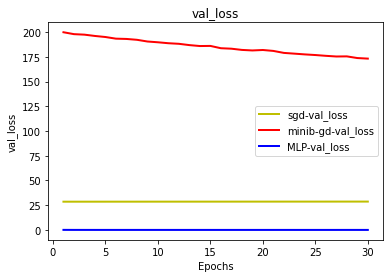

**************************************************


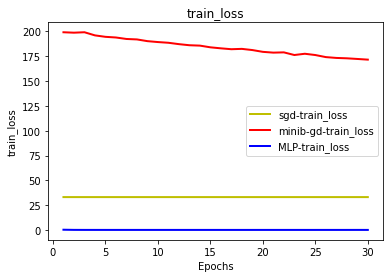

**************************************************


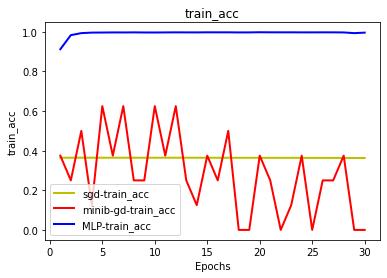

In [43]:
#because matrix will occupy a lot of memory, so we need to delete them and release memory
# %reset array
# %xdel theta_history_train

In [47]:
#*****************mini-batch loss plot****************************
# X_batch_list, y_batch_list = mini_batch(X_train, y_train, batch_size =8)
# J_history_train, theta_history_train, acc_history_train = mini_batch_GD(X_batch_list, y_batch_list, theta, \
#                                                    lr=1e-3, decay_factor = 0.99, \
#                                                    lambda_t=0.1, epochs=50, \
#                                                    optimizer='mini_batch', epsilon = 1e-1)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:45<00:00,  3.31s/it]


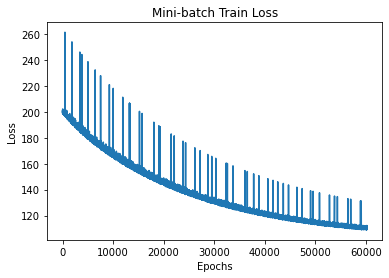

In [53]:
plt.plot(np.arange(len(J_history_train)), J_history_train)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Mini-batch Train Loss')
plt.show()

In [62]:
# %xdel theta_history_train

In [83]:
theta = theta_initial(X_train)
J_sgd_history_train, theta_sgd_history_train, acc_sgd_history_train= sgd_GD(X_train, y_train, theta, \
                                                   lr=0.008, decay_factor = 0.99, \
                                                   lambda_t=0.1, epochs=100, epsilon = 1e-3)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:34<00:00,  2.74s/it]


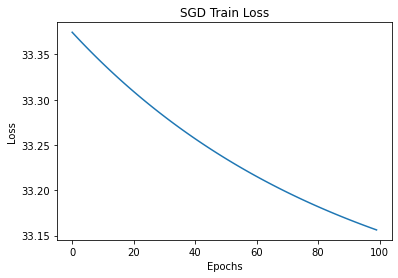

In [84]:
plt.plot(np.arange(len(J_sgd_history_train)), J_sgd_history_train)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SGD Train Loss')
plt.show()

In [38]:
#def plot():

# #plot val_loss, train_loss, train_acc
# dic = ['val_loss', 'train_loss', 'train_acc']

# #each model build one dictionary
# X_valid, y_valid = cross_val(X_vector_train, y_vector_train, theta)
# X_batch_list, y_batch_list = mini_batch(X_valid, y_valid, batch_size =8)
# J_history_valid, theta_history_valid, acc_history_valid = mini_batch_GD(X_batch_list, y_batch_list, theta, \
#                                                    lambda_t=0.1,X_train=X_train, y_train=y_train, \
#                                                     lr=1e-3, decay_factor = 0.99, \
#                                                     epochs=30, \
#                                                    optimizer='mini_batch', epsilon = 1e-1)

# X_batch_list, y_batch_list = mini_batch(X_vector_train, y_vector_train, batch_size =8)
# J_history_train, theta_history_train, acc_history_train = mini_batch_GD(X_batch_list, y_batch_list, theta, \
#                                                    lr=1e-3, decay_factor = 0.99, \
#                                                    lambda_t=0.1, epochs=30, \
#                                                    optimizer='mini_batch', epsilon = 1e-1)

# #y_hat, pred, accuracy = predict(X_vector_train, y_vector_train,theta_history_train)
# mini_batch = {dic[0]:J_history_valid, dic[1]:J_history_train, dic[2]:acc_history_train,}
# for i in range(len(dic)):

#     print("*"*50)
#     x_index = list(range(0,30))
#     plt.plot(x_index, mini_batch[dic[i]], color = 'g', lw = 2, label = 'mini_batch '+str(dic[i]))
#     print("*"*50)


# # J_history, grad_history, theta_history = sgd_GD(X_vector_train, y_vector_train, theta, \
# #                                                    lr=1e-3, decay_factor = 0.99, \
# #                                                    lambda_t=0.1, epochs=30, epsilon = 1e-3)



# # sgd = {dic[0]:J_history_valid, dic[1]:J_history_train, dic[2]:acc_history_train,}
    

<br>

<br>

<a id="10.Compare Conclusion"></a>
# 10.Compare Conclusion
<a href="#1.Summary">Click this Link back to Top</a>

if we don't use binomial in Logistic Regression, we only can get a line as our boundary, which is not perfect.

<ol>
    <li>We use two classifers, one is Logistic Regression and another is Neural Network. The big difference between these is Decsion Boundary. Decision boundary of LR is linear function, even in high dimension space, it is still a straight line. But decision boundary of Neural Network can fit non-linear classify task. So in this aspect, using LR in NLP task maybe not a good choice</li>
    <li>In NLP task, cleaning data occupy a dominated posion. Garbage in garbage out. If we didn't use a better cleaning algorithm, you will get good accuracy/performance even you use great model to fit. For this task, I believe I still have imporvement aspect and that is also a important reason i did't get beautiful plot.</li>
    <ul>
        <li>Using stemming and lemmatization for raw corpus. That is standard step for NLP task</li>
        <li>At present, I apply a rule which contain length of examples between 80% length and 20% length. This is only a mild stragegy. Within this strategy, I deleted too many valueable corpus. Drop raw corpus is not a good rule. Maybe droping raw corpus example by important and frequency is a good choice</li>
        <li>TFIDF is default choice. Maybe i can try embedding</li>
    </ul>
    <li>In cross-validation part, 5-flod cross-validation should be a good point, but I only use my own code to evluate one single paramaters</li>
    <li>Mini-batch is a more effective gradient descent algorithm compare to valina gradient descent. Especailly in NLP high dimension task, mini-batch will decreae runing time and increase convergence speed. But mini-bathc have its own difficult part.</li>
    <ul>
        <li>You have too decide your appropriate batch size acoording to corpus data type and your computer hardware configuration.</li>
        <li>Once you change batch size a little bit, you have too change other parameters correspondingly. If you don't change other parameters, like learning rate and lambda, you loss might not convergence</li>
    </ul>
    <li>Stochastic gradient descent is a more cost cheap choice. It will only import one example and will accelerate descent process.Most of important, I think in this NLP task, SGD is more appropriate than mini-batch. Because our corpus is one example one paragraph. If we use mini-batch shuffle every example, we will get a less meaning relationship combination, although they belong to a single Author. But SGD can matain a meaningful exmaple and train model with it.</li>
    <li>But the real problem of accuracy and performance is epochs number or laptop computation. You can see loss decrease from plot but not significant. If i have more powerful server, i can iterate 10 thousand times to get a small loss</li>
    <li>From this aspect, Neural network is good choice. NN use costless calculation to get a more valid result.</li>
    <li>There are a lot of aspect and algorithm i can apply. I record them in next chapter</li>
</ol>

<br>

<br>

# 12. Need Improve

<ol>
    <li>stemming and lemming</li>
    <li>shuffle corpus order</li>
    <li>plot length of sentence, eliminate that too long, and set MAX_LEN in a reasonable range</li>
    <li>import too much parameter for some complex function and need to build a GLOBAL hyperparamters system</li>
    <li>provide lr for every paramter, and momentoumn</li>
</ol>

<br>

# 12. Don't use code

In [39]:

"""
def load_data():
    file_path = "03_data/11_Project Gutenberg Data/28054-0.txt"
    
    f = open(file_path, 'r')
    print(f.read())

DIRECTORY_PATH = '03_data/11_Project Gutenberg Data/'
FILE_NAMES = ['28054-0.txt', 'pg1661.txt', 'pg31100.txt']

for name in FILE_NAMES:
    text_dir = tf.keras.utils.get_file(name, origin=DIRECTORY_PATH+name)
parent_dir = os.path.dirname(text_dir)

def labeler(example, index):
    return example, tf.cast(index, tf.int64)  

labeled_data_sets = []

for i, file_name in enumerate(FILE_NAMES):
    lines_dataset = tf.data.TextLineDataset(os.path.join(parent_dir, file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)



import scipy.sparse
def oneHotIt(Y):
    m = Y.shape[0]
    #Y = Y[:,0]
    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))
    OHX = np.array(OHX.todense()).T
    return OHX

import utils




 x=['a' , 'b']

x.extend(['5',  '6']),

x

len(x)

x =[0, 1, 2, 3, 4, 5, 6]

x[-3]

import numpy as np

x=np.random.random((3,4))

y = np.random.random((3,1))

x+y

x = np.random.random((3, 4))

for i in range(100,1000):
    for j in range(x.shape[1]):
        x[i,j] += 5

x[np.arange(100,1000), :] +=5

def test_fun(a=None):
    print(a)

test_fun(a=8)

vector_1.shape

vector_2 = np.random.randn(3,5)
vector_2

np.random.shuffle(vector_2)

vector_2

arr = np.arange(12).reshape(3,4)

arr

np.random.shuffle(arr)
arr



#     for train_index, valid_index in kf.split(X):
#         print("TRAIN:", len(train_index), "VALID:", len(valid_index))
#         X_train, X_valid = X[train_index,:], X[valid_index,:]
#         y_train, y_valid = y[train_index,:], y[valid_index,:]
#         J_history, grad_history, theta_history = mini_batch_GD(X_valid, y_valid, lambda_t = lambda_list[i])
#         i = i + 1
#         report = report(X_valid, y_valid)
#         report_list.append()




# This part is used for verify processing result
# #this will show which vector was transfromed back to words. We use this output to compare with corpus[0]

# vect.inverse_transform(data_4)[0]
# corpus[0]


"""

'\ndef load_data():\n    file_path = "03_data/11_Project Gutenberg Data/28054-0.txt"\n    \n    f = open(file_path, \'r\')\n    print(f.read())\n\nDIRECTORY_PATH = \'03_data/11_Project Gutenberg Data/\'\nFILE_NAMES = [\'28054-0.txt\', \'pg1661.txt\', \'pg31100.txt\']\n\nfor name in FILE_NAMES:\n    text_dir = tf.keras.utils.get_file(name, origin=DIRECTORY_PATH+name)\nparent_dir = os.path.dirname(text_dir)\n\ndef labeler(example, index):\n    return example, tf.cast(index, tf.int64)  \n\nlabeled_data_sets = []\n\nfor i, file_name in enumerate(FILE_NAMES):\n    lines_dataset = tf.data.TextLineDataset(os.path.join(parent_dir, file_name))\n    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))\n    labeled_data_sets.append(labeled_dataset)\n\n\n\nimport scipy.sparse\ndef oneHotIt(Y):\n    m = Y.shape[0]\n    #Y = Y[:,0]\n    OHX = scipy.sparse.csr_matrix((np.ones(m), (Y, np.array(range(m)))))\n    OHX = np.array(OHX.todense()).T\n    return OHX\n\nimport utils\n\n\n\n\n x=[\'a\

In [40]:

#This is another token way
"""
def token(dataset):

#     For now, we didn't use this function
#     Parameters:
#     -----------
#     dataset:list
#         Contain all raw data, we need use tokenizer to preprocess data
    
#     Return:
#     -------
#     tokenizer:tensorflow config

    #remove punctuation and irrelvant symbols
    #we use fillter to remove punctuation
    vocab_size = 100000
    max_length = 100
    
    tokenizer = Tokenizer(num_words=vocab_size, \
                          oov_token="<OOV>", \
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r”', 
                          lower=True
                         )
    #dataset_1 = tokenizer.get_config()

    #transfor sentence to number vector
    a = tokenizer.fit_on_texts(dataset)
    
    
        
    #get the index of each indivudule word
    word_index = tokenizer.word_index
    
    #only choose most frequency 10,000 word_index and transfrom sentences with them into number vector 
    #like[564, 452, 23, 1]
    #the out of vocabulary wiht be give 1. 
    #Maximize number of texts_to_sequences() will be 9999, which means the 10000th frequceny will 
    #not show in this sequcen
    sequences = tokenizer.texts_to_sequences(dataset)
    
    #maintain the sentence into same length
    #padded = pad_sequences(sequences)
    #If you want zero at the end, using padding='post'
    padded = pad_sequences(sequences, padding='post', maxlen=max_length, truncating='post')

    
    return tokenizer, word_index, sequences, padded

#tokenizer, word_index, sequences, padded = token(data_1)



len(corpus_train[8])

length_list=[]
length_corpus = len(corpus_6)
length_arr = np.zeros(length_corpus)
for i in range(0, length_corpus):
    #print(i)
    try:
        length_arr[i]=(len(corpus_6[i]))
    except:
        length_arr[i]=0
array_2 = np.arange(length_corpus) 
plt.plot(array_2, length_arr)

corpus_9['AUTHOR']

length_arr = np.zeros(length_corpus)
for i in range(0, length_corpus):
    #print(i)
    try:
        length_arr[i]=(len(corpus_9.iloc[i,0]))
    except:
        length_arr[i]=0
length_corpus = len(corpus_9)
array_3 = np.arange(length_corpus) 
plt.plot(array_3, length_arr)

plt.plot(array_3, np.sort(length_arr))

length_corpus = len(corpus_9)

length_corpus

plt.plot(array_2, np.sort(length_arr))

corpus_8['AUTHOR']

from scipy import stats
stats.describe(corpus_8['AUTHOR'])

len(length_arr)

len(length_arr[length_arr>600])

len(length_arr[length_arr<60])

len(length_arr[length_arr==0])

len(corpus_train[1235])



"""

'\ndef token(dataset):\n\n#     For now, we didn\'t use this function\n#     Parameters:\n#     -----------\n#     dataset:list\n#         Contain all raw data, we need use tokenizer to preprocess data\n    \n#     Return:\n#     -------\n#     tokenizer:tensorflow config\n\n    #remove punctuation and irrelvant symbols\n    #we use fillter to remove punctuation\n    vocab_size = 100000\n    max_length = 100\n    \n    tokenizer = Tokenizer(num_words=vocab_size,                           oov_token="<OOV>",                           filters=\'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r”\', \n                          lower=True\n                         )\n    #dataset_1 = tokenizer.get_config()\n\n    #transfor sentence to number vector\n    a = tokenizer.fit_on_texts(dataset)\n    \n    \n        \n    #get the index of each indivudule word\n    word_index = tokenizer.word_index\n    \n    #only choose most frequency 10,000 word_index and transfrom sentences with them into number vector \n